In [1]:
import cv2 as cv
import keras
import keras.applications as apps
import numpy as np
import os
import densenet
import glob

import tqdm
import matplotlib.pyplot as plt
import matplotlib
import random
plt.ion()

/home/paperspace/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:34: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.
/home/paperspace/anaconda3/lib/python3.6/importlib/_bootstrap.py:205: RuntimeWarning: compiletime version 3.5 of module 'tensorflow.python.framework.fast_tensor_util' does not match runtime version 3.6
  return f(*args, **kwds)


In [2]:
TILE_SIZE = 221

In [3]:
net = densenet.DenseNet121(include_top=True,
                      weights=None,
                      input_shape=(221, 221, 2),
                      pooling=None,
                      classes=1)

/home/paperspace/anaconda3/lib/python3.6/site-packages/keras/applications/imagenet_utils.py:258: UserWarning: This model usually expects 1 or 3 input channels. However, it was passed an input_shape with 2 input channels.
  str(input_shape[-1]) + ' input channels.')


In [4]:
def tile_image(HH, HV, conc, tile_size=221):
    # This function assumes all images are the same shape
    tile_center = tile_size//2
    amount_x = (HH.shape[0]//tile_size) -1
    amount_y = (HH.shape[1]//tile_size) -1
    sar_tiles = []
    conc_tiles = []
    for i in range(amount_x):
        for j in range(amount_y):
            x_bounds = [tile_size*i, tile_size*(i+1)]
            y_bounds = [tile_size*j, tile_size*(j+1)]
            conc_tile = conc[x_bounds[0]:x_bounds[1], y_bounds[0]:y_bounds[1]]
            if np.max(conc_tile) != 255:
                HH_tile = HH[x_bounds[0]:x_bounds[1],y_bounds[0]:y_bounds[1]]
                HV_tile = HV[x_bounds[0]:x_bounds[1],y_bounds[0]:y_bounds[1]]
                tile = np.stack([HH_tile, HV_tile],axis=-1)
                sar_tiles.append(tile)
                conc_tiles.append([conc_tile[tile_center, tile_center]])
    sar_tiles = np.asarray(sar_tiles).astype(np.float32)/255
    conc_tiles = np.asarray(conc_tiles).astype(np.float32)/100
    
    return sar_tiles, conc_tiles

In [5]:
# Utility methods to process/load images
def is_data_valid(folder_path):
    valid = os.path.exists(os.path.join(folder_path, 'imagery_HH.tif'))
    valid = valid and os.path.exists(os.path.join(folder_path, 'imagery_HV.tif')) 
    valid = valid and os.path.exists(os.path.join(folder_path, 'conc.tiff'))
    return valid

def read_data(folder):
    hh_image = cv.imread(os.path.join(folder, 'imagery_HH.tif'), cv.IMREAD_GRAYSCALE)
    hv_image = cv.imread(os.path.join(folder, 'imagery_HV.tif'), cv.IMREAD_GRAYSCALE)
    conc_image = cv.imread(os.path.join(folder, 'conc.tiff'), cv.IMREAD_GRAYSCALE)
    if conc_image is None:
        conc_image = np.ones(hh_image.shape)
    return hh_image, hv_image, conc_image

def tile_image(HH, HV, conc, tile_size=221):
    # This function assumes all images are the same shape
    tile_center = tile_size//2
    amount_x = (HH.shape[0]//tile_size) -1
    amount_y = (HH.shape[1]//tile_size) -1
    sar_tiles = []
    conc_tiles = []
    for i in range(amount_x):
        for j in range(amount_y):
            x_bounds = [tile_size*i, tile_size*(i+1)]
            y_bounds = [tile_size*j, tile_size*(j+1)]
            conc_tile = conc[x_bounds[0]:x_bounds[1], y_bounds[0]:y_bounds[1]]
            # check if the center of the tile is land or not
            if conc_tile[tile_center, tile_center] != 255:
                # set all values within the SAR image to by 255 if that part of the image is land
                HH_tile = np.where(conc_tile == 255,255,HH[x_bounds[0]:x_bounds[1],y_bounds[0]:y_bounds[1]])
                HV_tile = np.where(conc_tile == 255, 255, HV[x_bounds[0]:x_bounds[1],y_bounds[0]:y_bounds[1]])
                tile = np.stack([HH_tile, HV_tile],axis=-1)
                sar_tiles.append(tile)
                conc_tiles.append([conc_tile[tile_center, tile_center]])
    sar_tiles = np.asarray(sar_tiles).astype(np.float32)/255
    conc_tiles = np.asarray(conc_tiles).astype(np.float32)/100
    
    return sar_tiles, conc_tiles

def gen_tile_data(folder_name, images, labels, pos, dry_run=False, multiplier=1):
    amount = 0
    try:
        SHIFT = TILE_SIZE//multiplier
        hh_image, hv_image, conc_image = read_data(folder_name)
        conc_image_big = cv.resize(conc_image, hh_image.shape[0:2][::-1])
        for _ in range(multiplier):
            hh_image = hh_image[SHIFT:, SHIFT:]
            hv_image = hv_image[SHIFT:, SHIFT:]
            conc_image_big = conc_image_big[SHIFT:, SHIFT:]
            im_tiles, c_tiles = tile_image(hh_image, hv_image, conc_image_big)
            if not dry_run:
                images[pos+amount:pos + amount+ len(im_tiles)] = im_tiles
                labels[pos+amount:pos + amount + len(c_tiles)] = c_tiles
            amount = amount + len(im_tiles)
    except:
        print(folder_name)
    if dry_run:
        return amount
    return images, labels, pos + amount

In [6]:
def predict_image_fine(HH, HV, conc, model, tile_size=221):
#     Decimate
#     HH = cv.resize(HH, None, fx=0.5,fy=0.5)
#     HV = cv.resize(HV, None, fx=0.5,fy=0.5)
#     conc = cv.resize(conc, None, fx=0.5,fy=0.5)
    amount_x = ((HH.shape[0])//tile_size) -2
    amount_y = (HH.shape[1]//tile_size) -2
    scan_size = 3
    tile_center = tile_size//2

#     sar_tiles = []
    conc_image = np.ones((amount_x*(scan_size+1), amount_y*(scan_size+1)))*255
    sar_amount = 0
    for i in (range(amount_x)):
        for j in range(amount_y):
            for s in range(scan_size+1):
                for x in range(scan_size+1):
                    x_bounds = [int(tile_size*(i+ s/scan_size)), int(tile_size*(i+1 + s/scan_size))]
                    y_bounds = [int(tile_size*(j + x/scan_size)), int(tile_size*(j+1 + x/scan_size))]
                    conc_tile = conc[x_bounds[0]:x_bounds[1], y_bounds[0]:y_bounds[1]]
                    if conc_tile[tile_center, tile_center] < 255:
                        sar_amount += 1
    print(sar_amount)
    sar_arr = np.zeros((sar_amount, tile_size, tile_size, 2), dtype=np.float16)
    
    sar_count = 0
    for i in (range(amount_x)):
        for j in range(amount_y):
            for s in range(scan_size+1):
                for x in range(scan_size+1):
                    x_bounds = [int(tile_size*(i+ s/scan_size)), int(tile_size*(i+1 + s/scan_size))]
                    y_bounds = [int(tile_size*(j + x/scan_size)), int(tile_size*(j+1 + x/scan_size))]
                    conc_tile = conc[x_bounds[0]:x_bounds[1], y_bounds[0]:y_bounds[1]]
                    if conc_tile[tile_center, tile_center] < 255:
                        HH_tile = np.where(conc_tile == 255, 255,HH[x_bounds[0]:x_bounds[1],y_bounds[0]:y_bounds[1]])
                        HV_tile = np.where(conc_tile == 255, 255, HV[x_bounds[0]:x_bounds[1],y_bounds[0]:y_bounds[1]])
                        tile =np.stack([HH_tile, HV_tile],axis=-1)
                        tile = tile.astype(np.float16)/255
#                         sar_tiles.append(tile)
                        sar_arr[sar_count] = tile
                        sar_count += 1

#                         pred = model.predict(tile)
#                         pval = pred.flatten()[0]
#                         if pval > 1.5:
#                             pval = np.nan
#         #                 print('VAL:', pred)
# #                         conc_image[i,j] = pval
#                         conc_image[i*(scan_size+1)+s,j*(scan_size+1) + x] = pval
#                     else:
#                         conc_image[i*(scan_size+1)+s,j*(scan_size+1) + x] = np.nan
    preds = model.predict(sar_arr)
    p_ind = 0
    for i in (range(amount_x)):
            for j in range(amount_y):
                for s in range(scan_size+1):
                    for x in range(scan_size+1):
                        x_bounds = [int(tile_size*(i+ s/scan_size)), int(tile_size*(i+1 + s/scan_size))]
                        y_bounds = [int(tile_size*(j + x/scan_size)), int(tile_size*(j+1 + x/scan_size))]
                        conc_tile = conc[x_bounds[0]:x_bounds[1], y_bounds[0]:y_bounds[1]]
                        if conc_tile[tile_center, tile_center] < 255:
                            pval = preds[p_ind]
                            p_ind = p_ind + 1
                            if pval > 1.5:
                                pval = np.nan
#                             elif pval < 0.1:
#                                 pval = np.nan
            #                 print('VAL:', pred)
#                             conc_image[i,j] = pval
                            conc_image[i*(scan_size+1)+s,j*(scan_size+1) + x] = pval
                        else:
                            conc_image[i*(scan_size+1)+s,j*(scan_size+1) + x] = np.nan
#     conc_image = cv.resize(conc_image, None, fx=2, fy=2)
    return conc_image

In [7]:
def is_data_valid(folder_path):
    valid = os.path.exists(os.path.join(folder_path, 'imagery_HH.tif'))
    valid = valid and os.path.exists(os.path.join(folder_path, 'imagery_HV.tif')) 
#     valid = valid and os.path.exists(os.path.join(folder_path, 'conc.tiff'))
    return valid
    

In [8]:
def read_data(folder):
    hh_image = cv.imread(os.path.join(folder, 'imagery_HH.tif'), cv.IMREAD_GRAYSCALE)
    hv_image = cv.imread(os.path.join(folder, 'imagery_HV.tif'), cv.IMREAD_GRAYSCALE)
    conc_image = cv.imread(os.path.join(folder, 'conc.tiff'), cv.IMREAD_GRAYSCALE)
    return hh_image, hv_image, conc_image

In [9]:
folders = [f for f in glob.glob(os.path.join('lab_sea/2013_data/lab_sea/2013_data','RS2*')) if is_data_valid(f)]

In [10]:
folders = [f for f in glob.glob(os.path.join('training_data', '20*')) if is_data_valid(f)]

In [11]:
folders

['training_data/20110705',
 'training_data/20110405',
 'training_data/20110717C',
 'training_data/20110216',
 'training_data/20101007',
 'training_data/20110220',
 'training_data/20100131',
 'training_data/20110319',
 'training_data/20110717',
 'training_data/20100405',
 'training_data/20110717B',
 'training_data/20101213',
 'training_data/20110903',
 'training_data/20110903B',
 'training_data/20110903C',
 'training_data/20110213',
 'training_data/20110702',
 'training_data/20101221',
 'training_data/20110223',
 'training_data/20101009B',
 'training_data/20101205',
 'training_data/20101013',
 'training_data/20110214',
 'training_data/20110217',
 'training_data/20101009',
 'training_data/20110903D',
 'training_data/20100403',
 'training_data/20110730']

In [10]:
q = os.path.join('lab_sea/2013_data/images_gsl2014', os.listdir('lab_sea/2013_data/images_gsl2014')[0])

In [11]:
os.path.exists(os.path.join(q, 'imagery_HV.tif'))

True

In [12]:
is_data_valid(q)

True

  0%|          | 0/28 [00:00<?, ?it/s]

TRIAL: weights/net_checkpoint_FINAL.hdf5
RESULTS: net_checkpoint_FINAL_TRAIN
AD: 20110705.tiff
AD: 20110405.tiff


 11%|█         | 3/28 [00:00<00:04,  5.95it/s]

BAD:  training_data/20110717C
AD: 20110216.tiff
AD: 20101007.tiff
AD: 20110220.tiff
AD: 20100131.tiff
AD: 20110319.tiff
AD: 20110717.tiff
AD: 20100405.tiff


 39%|███▉      | 11/28 [00:01<00:01,  8.91it/s]

23064
BAD:  training_data/20110717B
AD: 20101213.tiff
AD: 20110903.tiff
AD: 20110903B.tiff
AD: 20110903C.tiff
AD: 20110213.tiff
AD: 20110702.tiff
AD: 20101221.tiff
AD: 20110223.tiff
AD: 20101009B.tiff
AD: 20101205.tiff
AD: 20101013.tiff


  0%|          | 0/10 [00:00<?, ?it/s]

30306
BAD:  training_data/20110214
AD: 20110217.tiff
AD: 20101009.tiff
AD: 20110903D.tiff
AD: 20100403.tiff
AD: 20110730.tiff
RESULTS: net_checkpoint_FINAL_MASKED_LAB
USING MASK mask_RS2_OK44069_PK425748_DK376117_SCWA_20130911_142657_HH_HV_SGF.tif
16755


 10%|█         | 1/10 [02:35<23:15, 155.06s/it]

USING MASK mask_RS2_OK45827_PK443017_DK394473_SCWA_20131112_105831_HH_HV_SGF.tif


 20%|██        | 2/10 [06:00<24:00, 180.02s/it]

22620
USING MASK mask_RS2_OK44073_PK425836_DK376184_SCWA_20130913_150901_HH_HV_SGF.tif
21629


 30%|███       | 3/10 [09:18<21:43, 186.20s/it]

USING MASK mask_RS2_OK44073_PK425834_DK376182_SCWA_20130913_132853_HH_HV_SGF.tif
15837


 40%|████      | 4/10 [11:43<17:34, 175.75s/it]

USING MASK mask_RS2_OK44067_PK425720_DK376088_SCWA_20130910_131728_HH_HV_SGF.tif
2803


 50%|█████     | 5/10 [12:08<12:08, 145.72s/it]

USING MASK mask_RS2_OK45827_PK443016_DK394472_SCWA_20131112_105716_HH_HV_SGF.tif
25667


 60%|██████    | 6/10 [16:02<10:41, 160.37s/it]

USING MASK mask_RS2_OK44073_PK425837_DK376185_SCWA_20130913_151015_HH_HV_SGF.tif
16411


 70%|███████   | 7/10 [18:31<07:56, 158.84s/it]

USING MASK mask_RS2_OK44073_PK425833_DK376181_SCWA_20130913_132739_HH_HV_SGF.tif
18597


 80%|████████  | 8/10 [21:19<05:19, 159.92s/it]

USING MASK mask_RS2_OK44067_PK425719_DK376087_SCWA_20130910_131613_HH_HV_SGF.tif
18338


 90%|█████████ | 9/10 [23:56<02:39, 159.66s/it]

USING MASK mask_RS2_OK45827_PK443004_DK394474_SCWA_20131112_105950_HH_HV_SGF.tif
7288


  0%|          | 0/29 [00:00<?, ?it/s]

RESULTS: net_checkpoint_FINAL_MASKED_GSL
MASKL mask_RS2_OK47591_PK460740_DK410448_SCWA_20140127_104734_HH_HV_SGF.tif
3905


  3%|▎         | 1/29 [00:33<15:40, 33.58s/it]

MASKL mask_RS2_OK47585_PK460578_DK410308_SCWA_20140124_103501_HH_HV_SGF.tif
11879


  7%|▋         | 2/29 [02:12<29:44, 66.10s/it]

MASKL mask_RS2_OK48327_PK464566_DK413629_SCWA_20140207_214938_HH_HV_SGF.tif
1174


 10%|█         | 3/29 [02:22<20:33, 47.43s/it]

MASKL mask_RS2_OK47600_PK463349_DK412398_SCWA_20140131_103053_HH_HV_SGF.tif
15090


 14%|█▍        | 4/29 [04:26<27:45, 66.61s/it]

MASKL mask_RS2_OK47583_PK460563_DK410297_SCWA_20140123_222627_HH_HV_SGF.tif
2928


 17%|█▋        | 5/29 [04:51<23:19, 58.31s/it]

MASKL mask_RS2_OK47581_PK464167_DK410878_SCWA_20140122_095247_HH_HV_SGF.tif
15119


 21%|██        | 6/29 [06:55<26:32, 69.23s/it]

MASKL mask_RS2_OK48331_PK464264_DK413375_SCWA_20140209_223030_HH_HV_SGF.tif
1842


 24%|██▍       | 7/29 [07:12<22:38, 61.76s/it]

MASKL mask_RS2_OK48333_PK464295_DK413403_SCWA_20140210_220111_HH_HV_SGF.tif
19445


 28%|██▊       | 8/29 [09:51<25:52, 73.92s/it]

MASKL mask_RS2_OK47585_PK460583_DK410313_SCWA_20140124_215646_HH_HV_SGF.tif
25392


 31%|███       | 9/29 [13:18<29:35, 88.77s/it]

MASKL mask_RS2_OK48327_PK463968_DK413138_SCWA_20140207_102631_HH_HV_SGF.tif
17584


 34%|███▍      | 10/29 [15:43<29:51, 94.31s/it]

MASKL mask_RS2_OK48329_PK463986_DK413159_SCWA_20140208_095758_HH_HV_SGF.tif
20807


 38%|███▊      | 11/29 [18:32<30:20, 101.14s/it]

VAD lab_sea/2013_data/images_gsl2014/RS2_OK47567_PK459339_DK409225_SCWA_20140116_223042_HH_HV_SGF
VAD lab_sea/2013_data/images_gsl2014/RS2_OK47581_PK464167_DK410275_SCWA_20140122_095247_HH_HV_SGF
VAD lab_sea/2013_data/images_gsl2014/RS2_OK48325_PK463943_DK413117_SCNA_20140206_105657_HH_HV_SGF
VAD lab_sea/2013_data/images_gsl2014/RS2_OK48333_PK464282_DK413391_SCWA_20140210_103911_HH_HV_SGF
VAD lab_sea/2013_data/images_gsl2014/RS2_OK47589_PK461345_DK410893_SCWA_20140126_223850_HH_HV_SGF
VAD lab_sea/2013_data/images_gsl2014/RS2_OK47591_PK460744_DK410452_SCWA_20140127_221027_HH_HV_SGF
VAD lab_sea/2013_data/images_gsl2014/RS2_OK48325_PK463954_DK413128_SCWA_20140206_221744_HH_HV_SGF
VAD lab_sea/2013_data/images_gsl2014/RS2_OK47593_PK463238_DK412299_SCWA_20140128_101751_HH_HV_SGF
VAD lab_sea/2013_data/images_gsl2014/RS2_OK47576_PK459465_DK409332_SCWA_20140120_105149_HH_HV_SGF
VAD lab_sea/2013_data/images_gsl2014/RS2_OK47587_PK464520_DK414734_SCWA_20140125_100500_HH_HV_SGF
VAD lab_sea/2013_dat

 90%|████████▉ | 26/29 [22:00<02:32, 50.77s/it] 

MASKL mask_RS2_OK47570_PK459345_DK409231_SCWA_20140117_103914_HH_HV_SGF.tif
9029


100%|██████████| 29/29 [23:14<00:00, 48.09s/it]


VAD lab_sea/2013_data/images_gsl2014/RS2_OK48319_PK463750_DK412941_SCWA_20140203_104323_HH_HV_SGF
VAD lab_sea/2013_data/images_gsl2014/RS2_OK47597_PK463281_DK412338_SCWA_20140130_222234_HH_HV_SGF


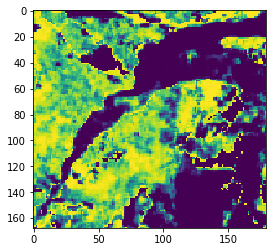

In [10]:
masks = [os.path.basename(f) for f in glob.glob('new_masks/*.tif')]
trails = ['weights/net_checkpoint_FINAL.hdf5']
for trial in trails:
    net.load_weights(trial)
    print("TRIAL:", trial)
    results_folder = os.path.basename(trial)[:-5] + '_TRAIN'
    folders = [f for f in glob.glob(os.path.join('training_data', '20*')) if is_data_valid(f)]
    print('RESULTS:', results_folder)
    os.makedirs(results_folder, exist_ok=True)
    for folder in tqdm.tqdm(folders):
        try:
            image_name = os.path.basename(folder) + ".tiff"
            image_path = os.path.join(results_folder, 'bigger_' + image_name)
            if (not os.path.exists(image_path)):

                hh_image, hv_image, conc_image = read_data(folder)
                if conc_image is None:
                    mask = [f for f in masks if os.path.splitext(image_name)[0] in f][0]

                    print('USING MASK')
                    conc_image = cv.imread(os.path.join('masks',mask), cv.IMREAD_GRAYSCALE)
                if conc_image is None:
                    print("BAAAD: ", folder)
                    continue
            #         conc_image_big = np.zeros(hh_image.shape)
                conc_image_big = cv.resize(conc_image, hh_image.shape[0:2][::-1])
                conc = predict_image_fine(hh_image, hv_image, conc_image_big, net)*200
                image_name = os.path.basename(folder) + ".tiff"
                mask_name = 'new_mask_' + image_name
                image_path = os.path.join(results_folder, 'bigger_' + image_name)
                mask_path = os.path.join(results_folder, mask_name)
                cv.imwrite(image_path, conc)
                new_mask  = np.isnan(conc).astype(np.uint8)*255
                cv.imwrite(mask_path, new_mask)
                plt.imshow(conc)
            else:
                print("AD: " + image_name)
        except:
            print("BAD: ", folder)
#     continue
    results_folder = os.path.basename(trial)[:-5] + '_MASKED_LAB'
    print("RESULTS:", results_folder)
    folders = [f for f in glob.glob(os.path.join('lab_sea/2013_data/lab_sea/2013_data','RS2*')) if is_data_valid(f)]
    os.makedirs(results_folder, exist_ok=True)
    for folder in tqdm.tqdm(folders):
        try:
            image_name = os.path.basename(folder) + ".tiff"
            image_path = os.path.join(results_folder, 'bigger_' + image_name)
            if (not os.path.exists(image_path)):
                hh_image, hv_image, conc_image = read_data(folder)
                if conc_image is None:
                    mask = [f for f in masks if os.path.splitext(image_name)[0] in f][0]
                    print('USING MASK', mask)
                    conc_image = cv.imread(os.path.join('new_masks',mask), cv.IMREAD_GRAYSCALE)
                if conc_image is None:
                    print("BAAAD: ", folder)
                    continue
            #         conc_image_big = np.zeros(hh_image.shape)
                conc_image_big = cv.resize(conc_image, hh_image.shape[0:2][::-1])
                conc = predict_image_fine(hh_image, hv_image, conc_image_big, net)*200
                image_name = os.path.basename(folder) + ".tiff"
                mask_name = 'new_mask_' + image_name
                image_path = os.path.join(results_folder, 'bigger_' + image_name)
                mask_path = os.path.join(results_folder, mask_name)
                cv.imwrite(image_path, conc)
                new_mask  = np.isnan(conc).astype(np.uint8)*255
                cv.imwrite(mask_path, new_mask)
                plt.imshow(conc)
            else:
                print("AD: " + image_name)
        except:
            print(folder)
    results_folder = os.path.basename(trial)[:-5] + '_MASKED_GSL'
    folders = [f for f in glob.glob(os.path.join('lab_sea/2013_data/images_gsl2014','RS2*')) if is_data_valid(f)]
    os.makedirs(results_folder, exist_ok=True)
    print("RESULTS:", results_folder)
    for folder in tqdm.tqdm(folders):
        try:
            image_name = os.path.basename(folder) + ".tiff"
            image_path = os.path.join(results_folder, 'bigger_' + image_name)
            if (not os.path.exists(image_path)):
                mask = [f for f in masks if os.path.splitext(image_name)[0] in f][0]
                print("MASKL", mask)
                hh_image, hv_image, conc_image = read_data(folder)
                conc_image = cv.imread(os.path.join('new_masks',mask), cv.IMREAD_GRAYSCALE)
                if conc_image is None:
                    print("BAAAD: ", folder)
                    continue
            #         conc_image_big = np.zeros(hh_image.shape)
                conc_image_big = cv.resize(conc_image, hh_image.shape[0:2][::-1])
                conc = predict_image_fine(hh_image, hv_image, conc_image_big, net)*200
                image_name = os.path.basename(folder) + ".tiff"
                mask_name = 'new_mask_' + image_name
                image_path = os.path.join(results_folder, 'bigger_' + image_name)
                mask_path = os.path.join(results_folder, mask_name)
                cv.imwrite(image_path, conc)
                new_mask  = np.isnan(conc).astype(np.uint8)*255
                cv.imwrite(mask_path, new_mask)
                plt.imshow(conc)
            else:
                print("AD: " + image_name)
        except:
            print('VAD',folder)

In [16]:
im = cv.imread(os.path.join('masks', mask),0)

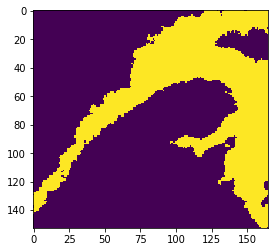

In [17]:
plt.imshow(im)

In [13]:
image_name

'RS2_OK47570_PK459345_DK409231_SCWA_20140117_103914_HH_HV_SGF.tiff'

In [18]:
mask

'new_maskRS2_OK47570_PK459345_DK409231_SCWA_20140117_103914_HH_HV_SGF.tiff'

In [30]:
net.load_weights('weights/net_checkpoint_AMORE_R4.hdf5')

In [31]:
results_folder = 'results_special_AMORE_R4_lab'
os.makedirs(results_folder, exist_ok=True)

  0%|          | 0/10 [00:00<?, ?it/s]

13813


 10%|█         | 1/10 [01:47<16:07, 107.48s/it]

21905


 20%|██        | 2/10 [04:35<18:22, 137.87s/it]

20399


 30%|███       | 3/10 [06:38<15:30, 132.86s/it]

lab_sea/2013_data/lab_sea/2013_data/RS2_OK44073_PK425836_DK376184_SCWA_20130913_150901_HH_HV_SGF
12686


 40%|████      | 4/10 [06:51<10:16, 102.81s/it]

lab_sea/2013_data/lab_sea/2013_data/RS2_OK44073_PK425834_DK376182_SCWA_20130913_132853_HH_HV_SGF


 50%|█████     | 5/10 [06:51<06:51, 82.33s/it] 

lab_sea/2013_data/lab_sea/2013_data/RS2_OK44067_PK425720_DK376088_SCWA_20130910_131728_HH_HV_SGF


 60%|██████    | 6/10 [06:52<04:34, 68.67s/it]

lab_sea/2013_data/lab_sea/2013_data/RS2_OK45827_PK443016_DK394472_SCWA_20131112_105716_HH_HV_SGF


 70%|███████   | 7/10 [06:52<02:56, 58.91s/it]

lab_sea/2013_data/lab_sea/2013_data/RS2_OK44073_PK425837_DK376185_SCWA_20130913_151015_HH_HV_SGF


 80%|████████  | 8/10 [06:52<01:43, 51.59s/it]

lab_sea/2013_data/lab_sea/2013_data/RS2_OK44073_PK425833_DK376181_SCWA_20130913_132739_HH_HV_SGF


 90%|█████████ | 9/10 [06:54<00:46, 46.00s/it]

lab_sea/2013_data/lab_sea/2013_data/RS2_OK44067_PK425719_DK376087_SCWA_20130910_131613_HH_HV_SGF


100%|██████████| 10/10 [06:54<00:00, 41.44s/it]

lab_sea/2013_data/lab_sea/2013_data/RS2_OK45827_PK443004_DK394474_SCWA_20131112_105950_HH_HV_SGF


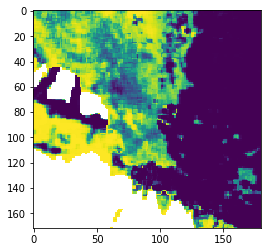

In [33]:
for folder in tqdm.tqdm(folders):
    try:
        image_name = os.path.basename(folder) + ".tiff"
        image_path = os.path.join(results_folder, 'bigger_' + image_name)
        if (not os.path.exists(image_path)) or True:
            mask = [f for f in masks if os.path.splitext(image_name)[0] in f][0]

            hh_image, hv_image, conc_image = read_data(folder)
            conc_image = cv.imread(os.path.join('masks',mask), cv.IMREAD_GRAYSCALE)
            if conc_image is None:
                print("BAAAD: ", folder)
                continue
        #         conc_image_big = np.zeros(hh_image.shape)
            conc_image_big = cv.resize(conc_image, hh_image.shape[0:2][::-1])
            conc = predict_image_fine(hh_image, hv_image, conc_image_big, net)*200
            image_name = os.path.basename(folder) + ".tiff"
            mask_name = 'new_mask_' + image_name
            image_path = os.path.join(results_folder, 'bigger_' + image_name)
            mask_path = os.path.join(results_folder, mask_name)
            cv.imwrite(image_path, conc)
            new_mask  = np.isnan(conc).astype(np.uint8)*255
            cv.imwrite(mask_path, new_mask)
            plt.imshow(conc)
        else:
            print("AD: " + image_name)
    except:
        print(folder)

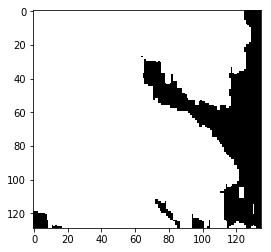

In [46]:
plt.imshow(cv.imread('masks/' + mask))

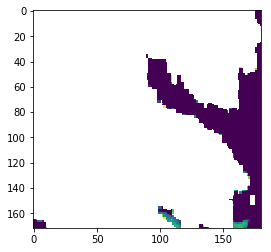

In [48]:
plt.imshow(conc)

In [ ]:
plt.imshow()

In [18]:
cv.imread()

TypeError: Required argument 'filename' (pos 1) not found

In [ ]:
new_mask

In [ ]:
new_mask.dtype

In [ ]:
plt.imshow(np.isnan(conc))

In [ ]:
np.nan

In [ ]:
new_mask.shape